# Example from Image Processing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

Here we'll take a look at a simple facial recognition example.
This uses a dataset available within scikit-learn consisting of a
subset of the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)
data.  Note that this is a relatively large download (~200MB) so it may
take a while to execute.

In [2]:
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')
lfw_people.data.shape

(1288, 1850)

If you're on a unix-based system such as linux or Mac OSX, these shell commands
can be used to see the downloaded dataset:

In [3]:
!ls datasets

20news-bydate-test      20news-bydate-train     20news-bydate.tar.gz    lfw_home                sentiment140            trainingandtestdata.zip


In [4]:
!du -sh datasets/lfw_home

273M	datasets/lfw_home


Let's visualize these faces to see what we're working with:

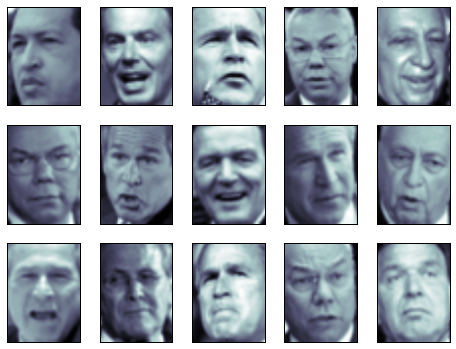

In [5]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap=plt.cm.bone)

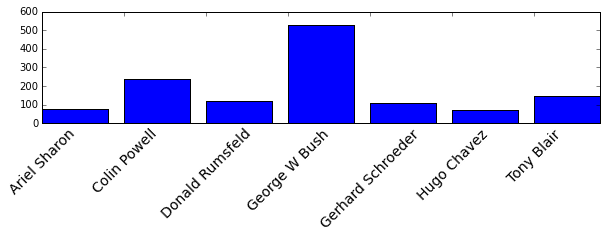

In [6]:
import numpy as np
plt.figure(figsize=(10, 2))

unique_targets = np.unique(lfw_people.target)
counts = [(lfw_people.target == i).sum() for i in unique_targets]

plt.xticks(unique_targets, lfw_people.target_names[unique_targets])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=14)
_ = plt.bar(unique_targets, counts)

One thing to note is that these faces have already been localized and scaled
to a common size.  This is an important preprocessing piece for facial
recognition, and is a process that can require a large collection of training
data.  This can be done in scikit-learn, but the challenge is gathering a
sufficient amount of training data for the algorithm to work

Fortunately, this piece is common enough that it has been done.  One good
resource is [OpenCV](http://opencv.willowgarage.com/wiki/FaceRecognition), the
*Open Computer Vision Library*.

We'll perform a Support Vector classification of the images.  We'll
do a typical train-test split on the images to make this happen:

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=0)

print(X_train.shape, X_test.shape)

(966, 1850) (322, 1850)


## Preprocessing: Principal Component Analysis

1850 dimensions is a lot for SVM.  We can use PCA to reduce these 1850 features to a manageable
size, while maintaining most of the information in the dataset.  Here it is useful to use a variant
of PCA called ``RandomizedPCA``, which is an approximation of PCA that can be much faster for large
datasets.  The interface is the same as the normal PCA we saw earlier:

In [8]:
from sklearn import decomposition
pca = decomposition.RandomizedPCA(n_components=150, whiten=True)
pca.fit(X_train)

RandomizedPCA(copy=True, iterated_power=3, n_components=150,
       random_state=None, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which can be
interesting to examine:

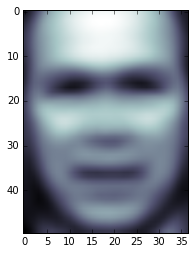

In [9]:
plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)

The principal components measure deviations about this mean along orthogonal axes.
It is also interesting to visualize these principal components:

In [10]:
print(pca.components_.shape)

(150, 1850)


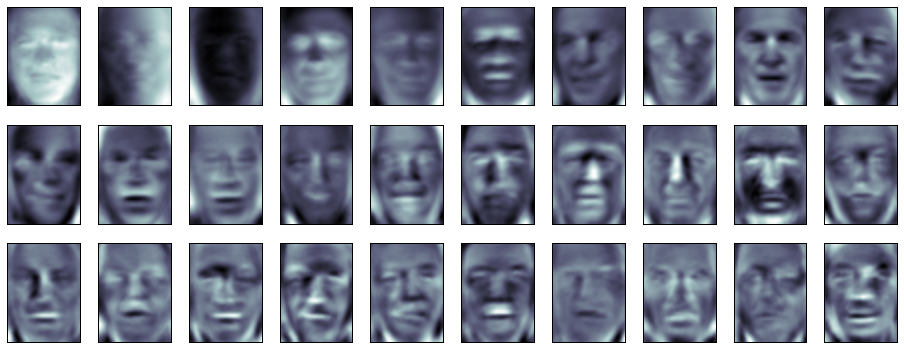

In [11]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from top-left to bottom-right.
We see that the first few components seem to primarily take care of lighting
conditions; the remaining components pull out certain identifying features:
the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:

In [12]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(966, 150)
(322, 150)


These projected components correspond to factors in a linear combination of
component images such that the combination approaches the original face.

## Doing the Learning: Support Vector Machines

Now we'll perform support-vector-machine classification on this reduced dataset:

In [14]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

Finally, we can evaluate how well this classification did.  First, we might plot a
few of the test-cases with the labels learned from the training set:

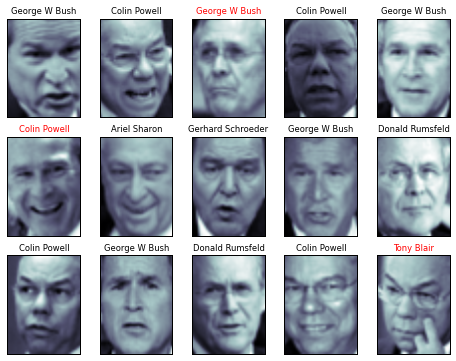

In [15]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i])[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    ax.set_title(lfw_people.target_names[y_pred], fontsize='small', color=color)

The classifier is correct on an impressive number of images given the simplicity
of its learning model!  Using a linear classifier on 150 features derived from
the pixel-level data, the algorithm correctly identifies a large number of the
people in the images.

Again, we can
quantify this effectiveness using one of several measures from the ``sklearn.metrics``
module.  First we can do the classification report, which shows the precision,
recall and other measures of the "goodness" of the classification:

In [16]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred, target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.64      0.73        28
     Colin Powell       0.76      0.90      0.83        63
  Donald Rumsfeld       0.90      0.75      0.82        24
    George W Bush       0.86      0.90      0.88       132
Gerhard Schroeder       0.76      0.80      0.78        20
      Hugo Chavez       0.93      0.64      0.76        22
       Tony Blair       0.84      0.82      0.83        33

      avg / total       0.84      0.84      0.83       322



Another interesting metric is the *confusion matrix*, which indicates how often
any two items are mixed-up.  The confusion matrix of a perfect classifier
would only have nonzero entries on the diagonal, with zeros on the off-diagonal.

In [17]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 18   5   0   4   1   0   0]
 [  1  57   0   2   0   1   2]
 [  0   3  18   3   0   0   0]
 [  2   8   2 119   0   0   1]
 [  0   0   0   2  16   0   2]
 [  0   1   0   5   2  14   0]
 [  0   1   0   3   2   0  27]]


In [18]:
print(metrics.f1_score(y_test, y_pred))

0.833169612999


/Users/User/src/scikit-learn/sklearn/metrics/classification.py:683: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


## Pipelining

Above we used PCA as a pre-processing step before applying our support vector machine classifier.
Plugging the output of one estimator directly into the input of a second estimator is a commonly
used pattern; for this reason scikit-learn provides a ``Pipeline`` object which automates this
process.  The above problem can be re-expressed as a pipeline as follows:

In [19]:
from sklearn.pipeline import Pipeline

In [20]:
clf = Pipeline([('pca', decomposition.RandomizedPCA(n_components=150, whiten=True)),
                ('svm', svm.LinearSVC(C=1.0))])

In [21]:
clf.fit(X_train, y_train)

Pipeline(steps=[('pca', RandomizedPCA(copy=True, iterated_power=3, n_components=150,
       random_state=None, whiten=True)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [22]:
y_pred = clf.predict(X_test)

In [23]:
print(metrics.confusion_matrix(y_pred, y_test))

[[ 19   4   0   0   2   0   1]
 [  2  47   3   6   0   1   0]
 [  1   2  17   6   0   0   2]
 [  2   4   3 109   1   5   1]
 [  2   0   0   5  12   3   4]
 [  0   1   0   2   1  12   0]
 [  2   5   1   4   4   1  25]]


The results are not identical because we used the randomized version of the PCA -- because the
projection varies slightly each time, the results vary slightly as well.

## A Quick Note on Facial Recognition

Here we have used PCA "eigenfaces" as a pre-processing step for facial recognition.
The reason we chose this is because PCA is a broadly-applicable technique, which can
be useful for a wide array of data types.  Research in the field of facial recognition
in particular, however, has shown that other more specific feature extraction methods
are can be much more effective.